# Laboratorium 4 - rekomendacje dla portali informacyjnych

## Przygotowanie

 * pobierz i wypakuj dataset: https://mind201910small.blob.core.windows.net/release/MINDsmall_train.zip
   * więcej możesz poczytać tutaj: https://learn.microsoft.com/en-us/azure/open-datasets/dataset-microsoft-news
 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab4`
 * zainstaluj potrzebne biblioteki:
 `pip install nltk sklearn`

## Część 1. - przygotowanie danych

In [2]:
# importujemy wszystkie potrzebne pakiety

import codecs
from collections import defaultdict # mozesz uzyc zamiast zwyklego slownika, rozwaz wplyw na czas obliczen
import math
import re
from string import punctuation

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

# mozesz uzyc do obliczania najbardziej podobnych tekstow zamiast liczenia "na piechote"
# ale pamietaj o dostosowaniu formatu danych
from sklearn.neighbors import NearestNeighbors

# na potrzeby wizualizacji
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from functools import reduce

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# definiujemy potrzebne zmienne

PATH = './'
STOPWORDS = set(stopwords.words('english'))

In [4]:
# wczytujemy metadane artykulow

def parse_news_entry(entry):
    news_id, category, subcategory, title, abstract = entry.split('\t')[:5]
    return {
        'news_id': news_id,
        'category': category,
        'subcategory': subcategory,
        'title': title,
        'abstract': abstract
    }

def get_news_metadata():
    with codecs.open(f'{PATH}/news.tsv', 'r', 'UTF-8') as f:
        raw = [x for x in f.read().split('\n') if x]
        parsed_entries = [parse_news_entry(entry) for entry in raw]
        return {x['news_id']: x for x in parsed_entries}

news = get_news_metadata()
news_ids = sorted(list(news.keys()))
news_indices = {x[1]: x[0] for x in enumerate(news_ids)}
print(len(news))

51282


In [5]:
def parse_history_entry(entry):
    _id, user_id, _time, history, _impressions = entry.split('\t')
    history = [x for x in history.split() if x]
    return user_id, history

def get_users_history():
    with codecs.open(f'{PATH}/behaviors.tsv', 'r', 'UTF-8') as f:
        lines = [x for x in f.read().split('\n') if x]
        entries = [parse_history_entry(x) for x in lines]
        return dict(entries)

users_history = get_users_history()
test_users = 'U53231', 'U89744', 'U10045', 'U92486', 'U70879'
print(len(users_history))

50000


## Część 2. - TF-IDF

In [50]:
# normalizujemy teksty na potrzeby dalszego przetwarzania

def preprocess_text(text):
    # zamieniamy wszystkie ciagi bialych znakow na pojedyncze spacje
    # usuwamy znaki interpunkcyjne
    # usuwamy wszystkie liczby
    # podmieniamy wszystkie wielkie litery
    # dzielimy na tokeny
    # usuwamy stopwords

    MapChain = [
        lambda text: re.sub(r'\s+', ' ', text),
        lambda text: ''.join(char for char in text if char not in punctuation),
        lambda text: re.sub(r'\d+', '', text),
        lambda text: text.lower(),
        lambda text: [token for token in text.split() if token not in STOPWORDS]
    ]
    
    return reduce(lambda acc, func: func(acc), MapChain, text)
#

def stem_texts(corpus):
    stemmer = LancasterStemmer()
    return [[stemmer.stem(word) for word in preprocess_text(text)] for text in corpus]

texts = [news[news_id]['abstract'] for news_id in news_ids]
stemmed_texts = stem_texts(texts)

In [51]:
# porownajmy teksty przed i po przetworzeniu

print(texts[2] + '\n')
print(' '.join(stemmed_texts[2]))

"I think we have a really good team, and a team that can really do some special, good things because that group is very close in there." - Brian Schmetzer

think real good team team real spec good thing group clos bri schmetzer


In [52]:
# tworzymy liste wszystkich slow w korpusie

def get_all_words_sorted(corpus):
    # generujemy posortowana alfabetycznie liste wszystkich slow (tokenow)
    return sorted(
        list(set([token for text in corpus for token in text]))
    )
#

wordlist = get_all_words_sorted(stemmed_texts)
word_indices = {x[1]: x[0] for x in enumerate(wordlist)}
print(len(wordlist))

37021


In [62]:
# obliczamy liczbe tekstow, w ktorych wystapilo kazde ze slow
# pamietaj, ze jesli slowo wystapilo w danym tekscie wielokrotnie, to liczymy je tylko raz

def get_document_frequencies(corpus, wordlist):
    # return {word -> count}
    frequencies = defaultdict(lambda: 0)

    # for word in wordlist:
    #     for text in corpus:
    #         if word in text:
    #             frequencies[word] += 1
    #             break 

    # for text in corpus:
    #     seen = set()
    #     for token in text:
    #         if token in seen: continue 
    #         seen.add(token)
    #         frequencies[token] += 1
    
    for text in corpus:
        for token in set(text):
            frequencies[token] += 1

    return frequencies
#

document_frequency = get_document_frequencies(stemmed_texts, wordlist)

In [63]:
print(document_frequency['aa'])

28


In [64]:
# obliczamy liczbe wystapien kazdego slowa w kazdym tekscie

def get_term_frequencies(corpus, news_indices):
    # return {news_id -> {word -> count}}
    frequencies = defaultdict(lambda: defaultdict(lambda: 0))

    for news_id, text in zip(news_indices, corpus):
        for token in text:
            frequencies[news_id][token] += 1
    #
    
    return frequencies
#

term_frequency = get_term_frequencies(stemmed_texts, news_indices)

In [65]:
# sprawdzmy wyniki

term_frequency[news_ids[2]]

defaultdict(<function __main__.get_term_frequencies.<locals>.<lambda>.<locals>.<lambda>()>,
            {'think': 1,
             'real': 2,
             'good': 2,
             'team': 2,
             'spec': 1,
             'thing': 1,
             'group': 1,
             'clos': 1,
             'bri': 1,
             'schmetzer': 1})

In [49]:
# def calculate_tf_idf(term_frequency, document_frequency, corpus_size):
#     # return {news_id -> {word -> tf_idf}}
#     return {news_id: {word: tf * math.log(corpus_size / df) for word, tf in tf_dict.items()} for news_id, tf_dict in term_frequency.items() for word, df in document_frequency.items() if word in tf_dict}

# tf_idf = calculate_tf_idf(term_frequency, document_frequency, len(news_ids))

In [68]:
# obliczamy metryke tf_idf

def calculate_tf_idf(term_frequency, document_frequency, corpus_size):
    # return {news_id -> {word -> tf_idf}}
    tf_idf = defaultdict(lambda: defaultdict(float))

    for news_id, word_freq_dict in term_frequency.items():
        for word, tf in word_freq_dict.items():
            df = document_frequency.get(word, 1)
            tf_idf[news_id][word] = tf * math.log(corpus_size / df)

    return tf_idf
#

tf_idf = calculate_tf_idf(term_frequency, document_frequency, len(news_ids))

In [109]:
# sprawdzmy wyniki

tf_idf[news_ids[2]]

defaultdict(float,
            {'think': 4.358934303449984,
             'real': 7.794316047558208,
             'good': 8.080961144662899,
             'team': 6.054134307726688,
             'spec': 4.4009638356936325,
             'thing': 4.111693200556713,
             'group': 4.260303700008357,
             'clos': 3.7360329567069006,
             'bri': 5.592821664347443,
             'schmetzer': 9.458800731274183})

## Część 3. - Podobieństwo tekstów

In [40]:
def cosine_similarity(tf_idf_1, tf_idf_2):
    nominator = sum([tf_idf_1[token] * tf_idf_2[token] for token in tf_idf_1 if token in tf_idf_2])
    denominator = math.sqrt(sum([tf_idf_1[token] ** 2 for token in tf_idf_1])) * math.sqrt(sum([tf_idf_2[token] ** 2 for token in tf_idf_2]))
    
    return nominator / denominator    

In [110]:
# obliczmy odleglosc miedzy dwoma artykulami
# przetestuj rozne metryki odleglosci i wybierz najlepsza

def calculate_distance(tf_idf, id1, id2):
    # if not id1 in tf_idf: return 0
    # if not id2 in tf_idf: return 0

    # nominator = sum([tf_idf[id1][token] * tf_idf[id2][token] for token in tf_idf[id1] if token in tf_idf[id2]])
    # denominator = math.sqrt(sum([tf_idf[id1][token] ** 2 for token in tf_idf[id1]])) * math.sqrt(sum([tf_idf[id2][token] ** 2 for token in tf_idf[id2]]))
    
    v1 = tf_idf.get(id1, {})
    v2 = tf_idf.get(id2, {})

    common_tokens = set(v1.keys()) & set(v2.keys())
    product = sum(v1[token] * v2[token] for token in common_tokens)

    distance_v1 = math.sqrt(sum(value ** 2 for value in v1.values()))
    distance_v2 = math.sqrt(sum(value ** 2 for value in v2.values()))
    
    if distance_v1 == 0.0 or distance_v2 == 0.0: return 1.0
    return 1 - product / (distance_v1 * distance_v2)
#

calculate_distance(tf_idf, news_ids[2], news_ids[1])

0.9511464152949101

In [111]:
# funkcja pomocnicza do wyswietlania artykulow
def print_news_entry(n_id, corpus):
    print(f'id: {n_id}\n\ttitle: {corpus[n_id]["title"]}\n\ttext: {corpus[n_id]["abstract"]}')

print_news_entry('N42782', news)

id: N42782
	title: Three takeaways from Yankees' ALCS Game 5 victory over the Astros
	text: The Yankees kept hope alive thanks to some impressive starting pitching and a pair of early home runs.


In [74]:
# wyznaczmy k najpodobniejszych tekstow do danego
# pamietaj o odpowiedniej kolejnosci sortowania w zaleznosci od wykorzystanej metryki
# pamietaj, zeby wsrod podobnych tekstow nie bylo danego

def get_k_most_similar_news(tf_idf, n_id, k):
    similarity = [(calculate_distance(tf_idf, n_id, n_id2), n_id2) for n_id2 in news_ids if n_id != n_id2]
    similarity.sort(key = lambda x: x[0])

    return [x[1] for x in similarity[:k]]
#

def print_k_most_similar_news(tf_idf, n_id, k, corpus):
    similar = get_k_most_similar_news(tf_idf, n_id, k)
    print_news_entry(n_id, corpus)
    print(f'\n{k} most similar:')
    for s_id in similar:
       print_news_entry(s_id, corpus)

print_k_most_similar_news(tf_idf, news_ids[42337], 5, news)

id: N58544
	title: Tiny Electric Car Cost $420,000 To Build
	text: A MAN claims he has created a car that might solve the world's traffic congestion problems. Rick Woodbury from Spokane, Washington USA, is the president, founder and sole employee of 'Commuter Cars.' The carmaker's flagship model is the 2005 super slim two-seater Tango T600, a high-performance electric car that preceded Tesla. Rick told BTV: "I started this company 21 years ago   it was based on an idea that I came up with in 1982." He was inspired by the shocking traffic congestion he had to face on a daily basis. "I used to drive a Porsche from Beverly Hills to Hermosa Beach every day and the traffic was horrendous," explained Rick. What really made Rick think about a solution was the fact that in most of the cars he would see in his commute were occupied by lone drivers. "I noticed that everybody around me was a single occupant in a car, taking up the whole lane," Rick said. Living and working in Los Angeles also hel

## Część 4. - Profile użytkowników

In [79]:
# oblicz srednia z wektorow tf-idf artykulow o zadanych id-kach
def calculate_average_vector(tf_idf, news_ids: list[str]) -> dict[str, float]:
    avg_vector = defaultdict(lambda: 0)
    
    for news_id in news_ids:
        text = tf_idf.get(news_id, {})
        for token, value in text.items():
            avg_vector[token] += value
    #
        
    count = len(news_ids)
    return {token: avg_vector[token] / count for token in avg_vector}
#

# wykorzystaj powyzsza funkcje, by policzyc wektor kazdego uzytkownika
def calculate_users_vectors(tf_idf, users_history) -> dict[str, list]:
    user_vectors = {}
    for user_id, news_ids in users_history.items():
        user_vectors[user_id] = calculate_average_vector(tf_idf, news_ids)
    return user_vectors
#

user_vectors = calculate_users_vectors(tf_idf, users_history)


In [80]:
# sprawdz wyliczony profil dla przykladowego uzytkownika
print(sorted([(k,v) for k,v in user_vectors[test_users[0]].items() if v], key=lambda x: -x[1]))

[('fir', 1.2673863655786257), ('ditch', 1.0497982187039419), ('diaz', 0.9848359105446637), ('land', 0.8835609329923807), ('acr', 0.8074483202148375), ('plan', 0.7873299886889074), ('ventur', 0.7780260164933531), ('flight', 0.7527351413211081), ('hailston', 0.7251391365595806), ('aircraft', 0.7197815043588195), ('storm', 0.6895002682711198), ('mar', 0.6421140887651202), ('tornado', 0.6380084961613199), ('noa', 0.6261181107653027), ('report', 0.6253912485455763), ('twoweek', 0.6177050367898467), ('airlin', 0.611710355929694), ('californ', 0.6009324718896504), ('contain', 0.5981148110881273), ('sant', 0.5725539516267156), ('paul', 0.5548573290301758), ('accord', 0.5427893691291458), ('ef', 0.5317069793379942), ('mcconnell', 0.5148220666191204), ('larg', 0.5140417407158352), ('behind', 0.5071744020955066), ('may', 0.5038884133953683), ('mitch', 0.4981352915347273), ('saud', 0.49241795527233184), ('hudson', 0.48972221755927137), ('lying', 0.4858602731828231), ('alleg', 0.4778465028638944), 

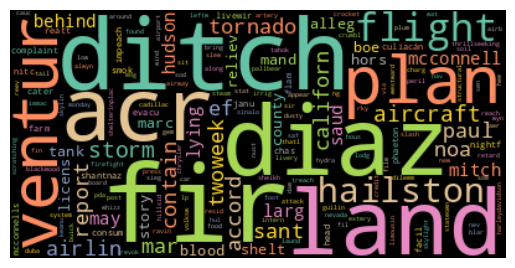

In [81]:
# skorzystajmy ze znanej juz biblioteki, by to lepiej zwizualizowac
def plot_vector(tf_idf_vector):
    wordcloud = WordCloud(random_state=42, background_color='black', colormap='Set2')
    wordcloud.generate_from_frequencies(frequencies=tf_idf_vector)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

plot_vector(user_vectors[test_users[0]])

## Część 5. - Rekomendacje dla użytkowników

In [116]:
def cosine_similarity(vec1, vec2):
    common_tokens = set(vec1.keys()) & set(vec2.keys())
    dot = sum(vec1[token] * vec2[token] for token in common_tokens)
    norm1 = math.sqrt(sum([a*a for a in vec1.values()]))
    norm2 = math.sqrt(sum([b*b for b in vec2.values()]))
    if norm1 == 0 or norm2 == 0:
        return 1.0
    return 1.0 - dot / (norm1*norm2)

def euclidean_distance(vec1, vec2):
    all_tokens = set(vec1.keys()) & set(vec2.keys())
    sum_sq_diff = sum((vec1[token] - vec2[token])**2 for token in all_tokens)
    return math.sqrt(sum_sq_diff)

In [118]:
# wykorzystujac wektory tresci i profile uzytkownikow,
#   wygeneruj liste k artykulow najlepiej dopasowanych do uzytkownika
#   pamietaj o odsianiu artykulow, ktore uzytkownik juz kliknal

def recommend(tf_idf, user_id, news, users_history, k):
    user_vector = user_vectors[user_id]
    read_articles = set(users_history.get(user_id, []))
    
    scores = []
    for news_id, doc_vector in tf_idf.items():
        if news_id in read_articles:
            continue
        sim = euclidean_distance(user_vector, doc_vector)
        scores.append((news_id, sim))
    
    scores.sort(key=lambda x: x[1])
    recommended_ids = [nid for nid,_ in scores[:k]]
    
    return recommended_ids
#

# dla wybranego uzytkownika, korzystajac z juz zaimplementowanych funkcji,
#   pokaz jego historie, profil (wordcloud) i rekomendacje


In [120]:
print(users_history[test_users[1]])
recommendations = recommend(tf_idf, test_users[1], news, users_history, 5)
for n_id in recommendations:
    print_news_entry(n_id, news)

['N24422', 'N25287', 'N39121', 'N41777', 'N58226', 'N119', 'N29197', 'N33727', 'N45189', 'N13480', 'N14167', 'N53494', 'N26040', 'N18094', 'N51458', 'N48222', 'N3812', 'N22561', 'N58264', 'N59289', 'N16541', 'N35488', 'N55141', 'N7534', 'N48423', 'N45794', 'N18939', 'N57967', 'N41832', 'N55051', 'N63411', 'N2533', 'N50748', 'N52631', 'N58090', 'N5092', 'N49689', 'N12349', 'N13057', 'N56638', 'N4885', 'N58997', 'N23554', 'N25604', 'N13286', 'N61342', 'N8448', 'N24578', 'N10417', 'N4693', 'N57528', 'N28149', 'N12215', 'N52145', 'N7132', 'N306', 'N8331', 'N11405', 'N28088', 'N49526', 'N42620', 'N55556', 'N25885', 'N38105', 'N43608', 'N62058', 'N8629', 'N22260', 'N27023', 'N8959', 'N63658', 'N16710', 'N55911', 'N10888', 'N2735', 'N53428', 'N8519', 'N4654']
id: N10
	title: 7 Running Workouts for Weight Loss
	text: It's all about the fartleks.
id: N10033
	title: HTC now has an entry-level blockchain phone
	text: The Exodus 1S is available to order now, but not in the US
id: N1004
	title: Sma

['N24422', 'N25287', 'N39121', 'N41777', 'N58226', 'N119', 'N29197', 'N33727', 'N45189', 'N13480', 'N14167', 'N53494', 'N26040', 'N18094', 'N51458', 'N48222', 'N3812', 'N22561', 'N58264', 'N59289', 'N16541', 'N35488', 'N55141', 'N7534', 'N48423', 'N45794', 'N18939', 'N57967', 'N41832', 'N55051', 'N63411', 'N2533', 'N50748', 'N52631', 'N58090', 'N5092', 'N49689', 'N12349', 'N13057', 'N56638', 'N4885', 'N58997', 'N23554', 'N25604', 'N13286', 'N61342', 'N8448', 'N24578', 'N10417', 'N4693', 'N57528', 'N28149', 'N12215', 'N52145', 'N7132', 'N306', 'N8331', 'N11405', 'N28088', 'N49526', 'N42620', 'N55556', 'N25885', 'N38105', 'N43608', 'N62058', 'N8629', 'N22260', 'N27023', 'N8959', 'N63658', 'N16710', 'N55911', 'N10888', 'N2735', 'N53428', 'N8519', 'N4654']


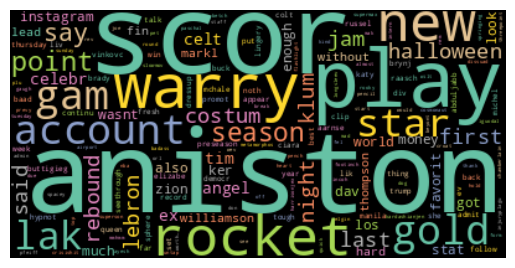

id: N25062
	title: James Harden scores 36 points, Rockets rout Warriors 129-112
	text: HOUSTON (AP)   James Harden had 36 points and 13 assists and the Houston Rockets routed Golden State 129-112 on Wednesday night, sending the short-handed Warriors to their sixth loss in eight games this season. Harden again appeared to be moving past his early shooting woes, going 6 of 16 from 3-point range. Since going 17 of 79 on 3s in his first six games, Harden has made 13 of 32 the last two. Russell Westbrook had 18 points, eight rebounds...
id: N12112
	title: Harden scores 39 points as Rockets beat Pelicans 122-116
	text: NEW ORLEANS (AP)   As usual, scoring comes in concentrated bursts for James Harden. Harden scored 19 of his 39 points in the fourth quarter and the Houston Rockets beat the short-handed New Orleans Pelicans 122-116 Monday night. The NBA's leading scorer has averaged 40.6 points in his last eight games, but missed nine of his first 10 3-point shots. Still, with Houston leading 

In [101]:
print(users_history[test_users[1]])
plot_vector(user_vectors[test_users[1]])
recommendations = recommend(tf_idf, test_users[1], news, users_history, 5)

for n_id in recommendations:
    print_news_entry(n_id, news)

## Część 6. - Ocena jakości

In [102]:
# jaccard index to metryka podobienstwa zbiorow, lekko ja zmodyfikujemy
# przeciecie wektorow to minimum po kazdej wspolrzednej
# unia wektorow to maksimum po kazdej wspolrzednej
# jaccard index to iloraz sum tych dwoch wartosci

def jaccard(v1, v2):
    all_tokens = set(v1.keys()) | set(v2.keys())
    
    intersection = sum(min(v1.get(token, 0), v2.get(token, 0)) for token in all_tokens)
    union = sum(max(v1.get(token, 0), v2.get(token, 0)) for token in all_tokens)
    
    if union == 0:
        return 0.0
    return intersection / union


In [113]:
# dla kazdego uzytkownika wygeneruj k-elementowa rekomendacje
# policz jaccard index miedzy wektorem uzytkownika a srednim wektorem elementow z rekomendacji
# porownaj wyniki dla dwoch roznych k i dwoch roznych metryk podobienstwa

for user_id, vec1 in user_vectors.items():
    recommendations_ids = recommend(tf_idf, user_id, news, users_history, 5)
    vec2 = calculate_average_vector(tf_idf, recommendations_ids)
    score = jaccard(vec1, vec2)
    print(f'{user_id}: {score}')


U13740: 0.13913987163603755
U91836: 0.05012888262133705
U73700: 0.044327937446551786
U34670: 0.07924989346772524
U8125: 0.15116050577427315
U19739: 0.08542124360803767
U8355: 0.047334553837962985
U46596: 0.30662432783677807


KeyboardInterrupt: 

In [114]:
for user_id, vec1 in user_vectors.items():
    recommendations_ids = recommend(tf_idf, user_id, news, users_history, 2)
    vec2 = calculate_average_vector(tf_idf, recommendations_ids)
    score = jaccard(vec1, vec2)
    print(f'{user_id}: {score}')

U13740: 0.07523347916575839
U91836: 0.030671427162894154
U73700: 0.028515878462492077
U34670: 0.036171257205148785
U8125: 0.07481004835453745
U19739: 0.037503723570538355
U8355: 0.040636945178543445
U46596: 0.3325772210554866


KeyboardInterrupt: 